# Classification. Linear models and KNN

In [111]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [20]:
from sklearn.exceptions import NotFittedError

In [21]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""       
        return 1/(1 + np.exp(-np.dot(X, weights)) )  
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        x = np.hstack([np.ones((x.shape[0], 1)), x])
        N = len(y)
        return 1/N * (np.log(1 + np.exp(-np.dot(x, weights)*y))).sum()
        + 1/(2*self.C) * np.linalg.norm(weights)**2
    
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        N = len(y)
        for i in range(self.max_iter):
            grad = 0
            for j in range(N):
                grad += y[j] * X_ext[j] * (1 - 1/(1 + np.exp(-np.dot(self.weights_, X_ext[j])*y[j])))
            delta = 1/N * grad - 1 / self.C * self.weights_
            self.weights_ += self.eta * delta
        
            if np.linalg.norm(self.weights_ - delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            num_features = X_ext.shape[1]
            return self.get_sigmoid(X_ext, np.zeros(num_features))
    
    def predict(self, X):
        
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        sigmoid_p = self.get_sigmoid(X_ext, self.weights_)
        sigmoid_p[sigmoid_p < 0.5] = -1
        sigmoid_p[sigmoid_p >= 0.5] = 1
        return sigmoid_p

In [22]:
from sklearn import datasets
from sklearn import metrics

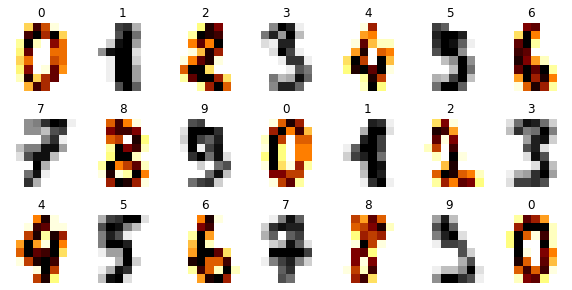

In [23]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# y_train = "<your code>"
# y_test = "<your code>"

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [24]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [25]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [26]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [27]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [28]:
lr_clf.fit(X_train, y_train)

In [29]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [30]:
model = CustomLogisticRegression(tol=0.01)

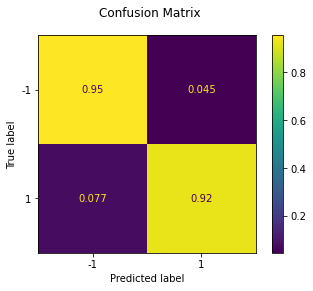

In [31]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [32]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [33]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [35]:
iter = 100
history_train_loss = []
history_test_loss = []
for i in range(0, iter, 2):
    model = CustomLogisticRegression(max_iter=i, zero_init=True)
    model.fit(X_train, y_train)
    
    history_train_loss.append((i,model.get_loss(X_train, model.weights_, y_train)))
    history_test_loss.append((i,model.get_loss(X_test, model.weights_, y_test)))

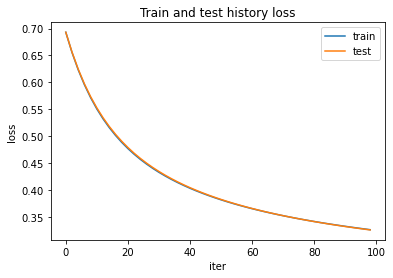

In [36]:
plt.title('Train and test history loss')
plt.xlabel('iter')
plt.ylabel('loss')
plt.plot(*zip(*history_train_loss), label = 'train')
plt.plot(*zip(*history_test_loss), label = 'test')
plt.legend()
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [37]:
history_lr_train_loss = []
history_lr_test_loss = []
eta = 1e-5
for k in tqdm(range(1, 1000, 10)):
    model = CustomLogisticRegression(max_iter = 20, eta=k * eta, zero_init=True)
    model.fit(X_train, y_train)
    
    history_lr_train_loss.append((k*eta, model.get_loss(X_train, model.weights_, y_train)))
    history_lr_test_loss.append((k*eta, model.get_loss(X_test, model.weights_, y_test)))

100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


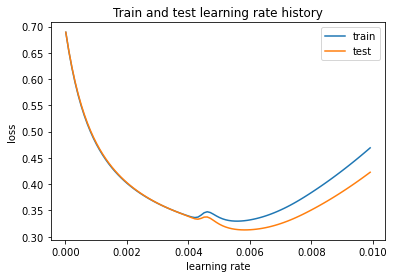

In [38]:
plt.title('Train and test learning rate history')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.plot(*zip(*history_lr_train_loss), label='train')
plt.plot(*zip(*history_lr_test_loss), label='test')
plt.legend()
plt.show()

We see that with an increase in the number of iterations, we see a drop in loss, this indicates a correctly built model and good data.
 Also, with an increase in the learning rate, the loss asymptotically begins to increase. That's right, because our step becomes too large, so the gradient is found with a larger error. It would be great to choose the optimal step.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [39]:
history_C_train_loss = []
history_C_test_loss = []
eta = 1e-5
for c in tqdm(np.arange(0.1, 2, 0.1)):
    model = CustomLogisticRegression(C=c, max_iter = 100, zero_init=True)
    model.fit(X_train, y_train)
    
    history_C_train_loss.append((c, model.get_loss(X_train, model.weights_, y_train)))
    history_C_test_loss.append((c, model.get_loss(X_test, model.weights_, y_test)))

100%|██████████| 19/19 [01:04<00:00,  3.41s/it]


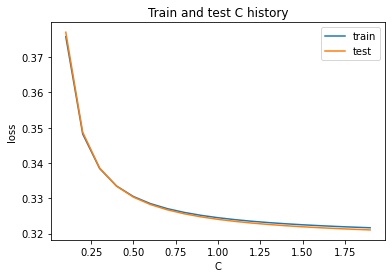

In [40]:
plt.title('Train and test C history')
plt.xlabel('C')
plt.ylabel('loss')
plt.plot(*zip(*history_C_train_loss), label='train')
plt.plot(*zip(*history_C_test_loss), label='test')
plt.legend()
plt.show()

Interestingly, as the regularization constant increases, we see a decrease in losses. Most likely due to the fact that we penalize the model more for retraining

**(0.5 points)** Compare zero initialization and random initialization. 

In [41]:
model_zero_init = CustomLogisticRegression(zero_init=True)
model_rand_init = CustomLogisticRegression(zero_init=False)

model_zero_init.fit(X_train, y_train)
model_rand_init.fit(X_train, y_train)

In [42]:
loss_zero_train = model_zero_init.get_loss(X_train, model_zero_init.weights_, y_train)
loss_zero_test = model_zero_init.get_loss(X_test, model_zero_init.weights_, y_test)

loss_rand_train = model_rand_init.get_loss(X_train, model_rand_init.weights_, y_train)
loss_rand_test = model_rand_init.get_loss(X_test, model_rand_init.weights_, y_test)

l = [[loss_zero_train, loss_zero_test], [loss_rand_train, loss_rand_test]]

In [43]:
df = pd.DataFrame(columns=['train', 'test'], index=['zero', 'rand'], data=l)
df

,train,test
zero,0.236646,0.233372
rand,0.236569,0.233271


<AxesSubplot:>

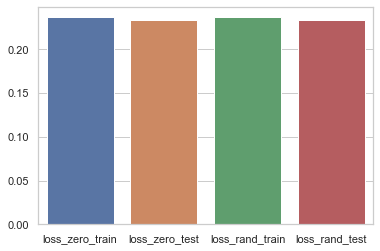

In [44]:
sns.set_theme(style="whitegrid")
sns.barplot(y=[loss_zero_train, loss_zero_test, loss_rand_train, loss_rand_test], 
            x =['loss_zero_train', 'loss_zero_test', 'loss_rand_train', 'loss_rand_test'])

As we can see, the initialization has almost no effect on the further training of the model. This is due to the fact that in the process of correct training, we refine the weights as we need and the loss remains approximately the same in rand and at zero.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [47]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """

        return np.sqrt(((np.expand_dims(X, 0) - np.expand_dims(Y, 1))**2).sum(axis=-1)).T
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.ones(len(self.classes_))
        
        for i in range(len(self.classes_)):
            w = 0
            for j in range(len(y)):
                if self.classes_[i] == y[j]:
                    w += weights[j]
            p[i] = w
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            nearest = P.argsort(axis=1)[:, :self.n_neighbors]
            dist = P[np.arange(P.shape[0])[:,None], nearest]
            labels = self.y[nearest]
            weights_ = np.ones(labels.shape)
            if self.weights == 'distance':
                weights_ = 1 / (dist + self.eps)
            count_labels = np.array([self.get_class_weights(labels[i], weights_[i]) for i in range(len(P))])
            weights_of_points = count_labels / np.expand_dims(count_labels.sum(axis=1), 1)
            return np.array(weights_of_points)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.argmax(self.predict_proba(X), axis=1)

In [48]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [49]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [50]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

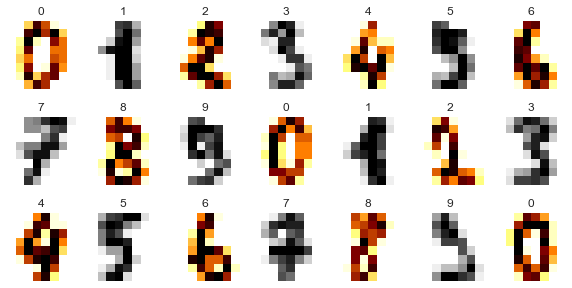

In [51]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [52]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [56]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

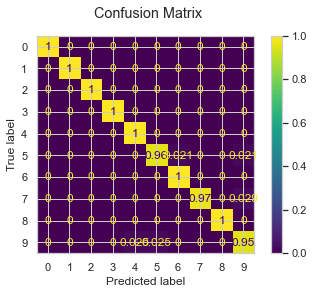

In [57]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [58]:
train_acc, test_acc

(1.0, 0.9861111111111112)

In [59]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model confuses 5 and 6, 9; 7 and 9; 9 and 4, 5
this is due to the fact that these numbers on the letter are very similar

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [60]:
K = 20
history_k = []
for k in range(1, K+1):
    model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train, y_train)
    history_k.append((k, model.predict_proba(X_test).max(axis=1).min()))

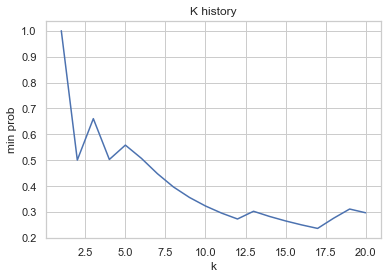

In [61]:
plt.title('K history')
plt.xlabel('k')
plt.ylabel('min prob')
plt.plot(*zip(*history_k))
plt.show()

It is interesting that at large parameters, the model is, as it were, refined

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

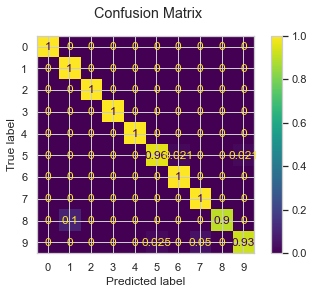

In [62]:
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

In [63]:
train_acc, test_acc

(0.97633959638135, 0.9777777777777777)

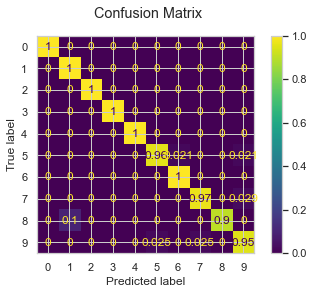

In [64]:
knn = KNeighborsClassifier(n_neighbors=20, weights='distance')
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

In [65]:
train_acc, test_acc

(1.0, 0.9777777777777777)

distance is more prone to retraining, because it takes all neighbors, unlike uniform, which takes into account even those who are a little further away

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

cosine, euclidean, minkowski, seuclidean, ect.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

When I did text recognition, I turned sentences into vectors and used cosine distance.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [66]:
PATH = "./data/"

In [135]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [136]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [137]:
print('male count: ', len(data[data['Sex'] == 'male']))
print('female count: ', len(data[data['Sex'] == 'female']))

print('male survived: ', len(data[(data['Survived'] == 1) & (data['Sex'] == 'male')]))
print('female survived: ', len(data[(data['Survived'] == 1) & (data['Sex'] == 'female')]))

male count:  56114
female count:  43886
male survived:  11548
female survived:  31226


<AxesSubplot:xlabel='Sex', ylabel='count'>

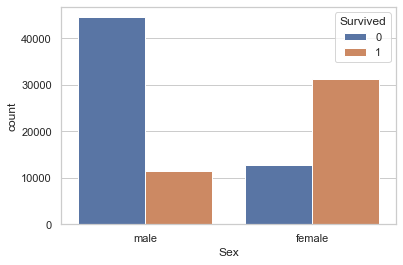

In [138]:
sns.countplot(x='Sex',hue='Survived',data=data)

The men were gentlemen, so more girls survived

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

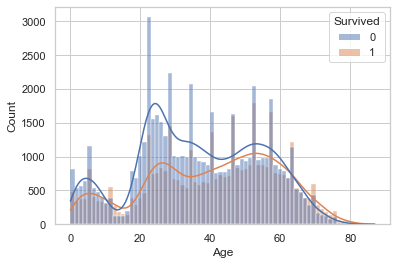

In [139]:
sns.histplot(x='Age', hue='Survived', data=data, kde=True)

In [140]:
print('median survivors:', data[data['Survived'] == 1]['Age'].median())
print('median deaths:', data[data['Survived'] == 0]['Age'].median())

print('mean survivors:', data[data['Survived'] == 1]['Age'].mean())
print('mean deaths:', data[data['Survived'] == 0]['Age'].mean())

median survivors: 43.0
median deaths: 36.0
mean survivors: 40.55379931430776
mean deaths: 36.708694881533724


Survivors are older on average and median, possibly because they had a higher status

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='Embarked'>

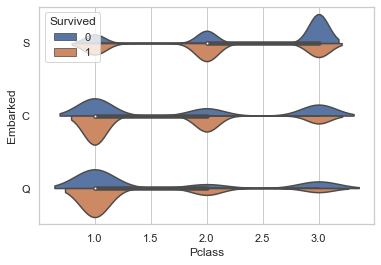

In [141]:
sns.violinplot (x = 'Pclass', y = 'Embarked', hue = 'Survived', split = True, data = data)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

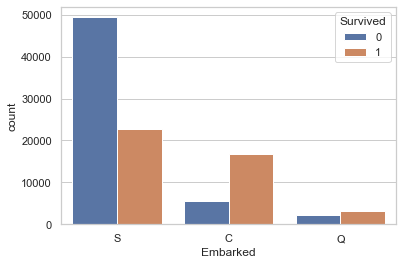

In [142]:
sns.countplot(x='Embarked',hue='Survived',data=data)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

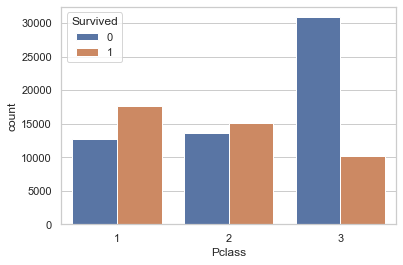

In [143]:
sns.countplot(x='Pclass',hue='Survived',data=data)

More survivors in class 1, as well as the largest number of survivors in C embarked

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

<AxesSubplot:ylabel='PassengerId'>

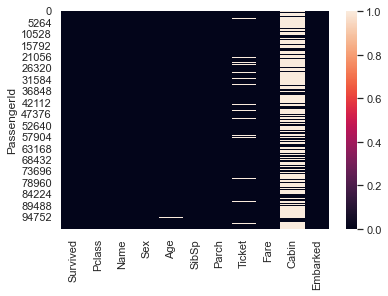

In [144]:
sns.heatmap(data.isna())

In [145]:
for col in data.columns:
    missing = np.mean(data[col].isnull()) * 100
    print('{} - {}%'.format(col, missing))

Survived - 0.0%
Pclass - 0.0%
Name - 0.0%
Sex - 0.0%
Age - 3.292%
SibSp - 0.0%
Parch - 0.0%
Ticket - 4.623%
Fare - 0.134%
Cabin - 67.866%
Embarked - 0.25%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

The sign of the cabin is not informative, although you can try to create a column that will say whether there is data about the cabin or not

Fill in the age with the median

Tickets can simply be dropped, because it is definitely difficult to predict any information from them. Although you could try to highlight the first letter

Summary: the advantages of such methods are that they are simple, but we may lose some information

In [150]:
Embarked = data.groupby('Embarked').count()
MaxEmbarked = Embarked[Embarked == Embarked.max()].index[0]
data.Embarked[data.Embarked.isnull()] = MaxEmbarked
data.Embarked[data.Embarked.isnull()].count()

0

In [151]:

data.Age[data.Age.isnull()] = data.Age.median()
len(data[data.Age.isnull()])

0

In [160]:
data.Fare[data.Fare.isnull()] = data.Fare.median()
len(data[data.Fare.isnull()])

0

In [152]:
data['has_cabin'] = 1
data['has_cabin'][data.Cabin.isnull()] = 0
data.drop(columns="Cabin", axis=1,inplace=True)

In [153]:
data.drop("Name", axis=1, inplace=True)
data.drop("Ticket", axis=1, inplace=True)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,has_cabin
PassengerId,,,,,,,,,
0,1,1,male,39.00,2,0,27.14,S,1
1,0,3,male,39.00,0,0,13.35,S,0
2,0,3,male,0.33,1,2,71.29,S,0
3,0,3,male,19.00,0,0,13.04,S,0
4,1,3,male,25.00,0,0,7.76,S,0
...,...,...,...,...,...,...,...,...,...
99995,1,2,female,62.00,0,0,14.86,C,1
99996,0,2,male,66.00,0,0,11.15,S,0
99997,0,3,male,37.00,0,0,9.95,S,0


In [154]:
data['Sex'][data['Sex'] == 'male'] = 0
data['Sex'][data['Sex'] == 'female'] = 1

In [161]:
data['Sex'] = data['Sex'].astype(np.int64)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Survived   100000 non-null  int64  
 1   Pclass     100000 non-null  int64  
 2   Sex        100000 non-null  int64  
 3   Age        100000 non-null  float64
 4   SibSp      100000 non-null  int64  
 5   Parch      100000 non-null  int64  
 6   Fare       100000 non-null  float64
 7   Embarked   100000 non-null  int64  
 8   has_cabin  100000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 9.6 MB


In [162]:
data['Embarked'].unique()

array([1, 2, 3], dtype=int64)

In [163]:
data['Embarked'][data['Embarked'] == 'S'] = 1
data['Embarked'][data['Embarked'] == 'C'] = 2
data['Embarked'][data['Embarked'] == 'Q'] = 3
data['Embarked'] = data['Embarked'].astype(np.int64)

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Survived   100000 non-null  int64  
 1   Pclass     100000 non-null  int64  
 2   Sex        100000 non-null  int64  
 3   Age        100000 non-null  float64
 4   SibSp      100000 non-null  int64  
 5   Parch      100000 non-null  int64  
 6   Fare       100000 non-null  float64
 7   Embarked   100000 non-null  int64  
 8   has_cabin  100000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 9.6 MB


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [219]:
model = KNeighborsClassifier()
Y = data['Survived'].to_frame()
X = data.drop(columns='Survived')
model.fit(X, Y)
results = cross_validate(model, X, Y, cv=5, scoring='accuracy', return_train_score=True)

In [220]:
print(np.mean(results['train_score']))
print(np.mean(results['test_score']))

0.8059200000000001
0.72187


In [207]:
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [216]:
Embarked = test.groupby('Embarked').count()
MaxEmbarked = Embarked[Embarked == Embarked.max()].index[0]
test.Embarked[test.Embarked.isnull()] = MaxEmbarked
test.Embarked[test.Embarked.isnull()].count()

0

In [209]:
test.Age[test.Age.isnull()] = test.Age.median()
len(test[test.Age.isnull()])

0

In [210]:
test.Fare[test.Fare.isnull()] = test.Fare.median()
len(data[test.Fare.isnull()])

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [211]:
test['has_cabin'] = 1
test['has_cabin'][test.Cabin.isnull()] = 0
test.drop(columns="Cabin", axis=1,inplace=True)

In [212]:
test.drop("Name", axis=1, inplace=True)
test.drop("Ticket", axis=1, inplace=True)
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,has_cabin
PassengerId,,,,,,,,
100000,3,male,19.0,0,0,63.01,S,0
100001,3,female,53.0,0,0,5.81,S,0
100002,1,female,19.0,0,0,38.91,C,1
100003,2,male,25.0,0,0,12.93,S,0
100004,1,female,17.0,0,2,26.89,C,1
...,...,...,...,...,...,...,...,...
199995,3,female,27.0,0,0,10.12,Q,0
199996,1,male,59.0,1,0,68.31,S,0
199997,3,male,47.0,0,0,10.87,S,0


In [213]:
test['Sex'][test['Sex'] == 'male'] = 0
test['Sex'][test['Sex'] == 'female'] = 1

In [214]:
test['Sex'] = test['Sex'].astype(np.int64)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100000 to 199999
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Pclass     100000 non-null  int64  
 1   Sex        100000 non-null  int64  
 2   Age        100000 non-null  float64
 3   SibSp      100000 non-null  int64  
 4   Parch      100000 non-null  int64  
 5   Fare       100000 non-null  float64
 6   Embarked   100000 non-null  object 
 7   has_cabin  100000 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 8.9+ MB


In [217]:
test['Embarked'][test['Embarked'] == 'S'] = 1
test['Embarked'][test['Embarked'] == 'C'] = 2
test['Embarked'][test['Embarked'] == 'Q'] = 3
test['Embarked'] = test['Embarked'].astype(np.int64)

In [221]:
y_test = model.predict(test)

In [225]:
sub = pd.DataFrame()
sub['PassengerId'] = test.index
sub['Survived'] = y_test

In [226]:
sub.to_csv('data/titanic/my_submission.csv', index=False)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

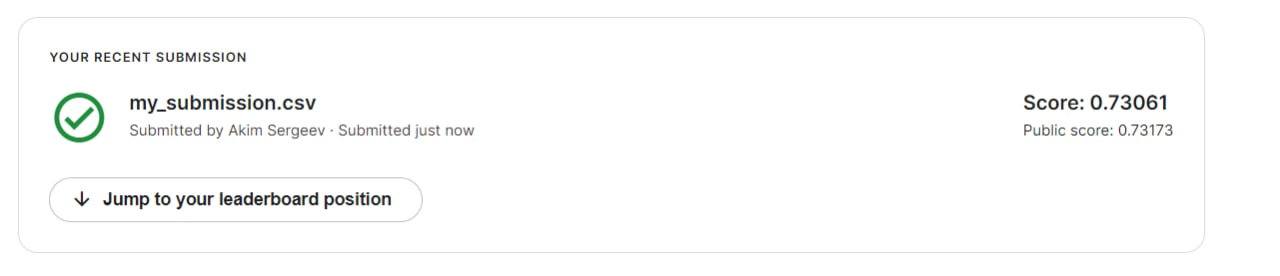

In [228]:
from IPython.display import Image
Image('sub.jpg')

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.